# 삼성 DS-KAIST AI Expert 프로그램
## Visual Question Answering

실습 일시: 2020년 8월 5일 (수)

담당 조교: 정종헌 (jongheonj@kaist.ac.kr), 박종진 (jongjin.park@kaist.ac.kr)

## Introduction

본 실습에서는 강의 내용을 바탕으로 다양한 VQA 모델을 직접 구현 및 학습해보는 것을 목표로 합니다. 본 실습은 총 5 파트로 구성됩니다:

* **Part 1. Sort-of-CLEVR 데이터셋 파악**
* **Part 2. Relation Networks 구현**
* **Part 3. FiLM-based Model 구현**
* **Part 4. 구현 모델 간 성능 비교 분석**
* **Part 5. 모델 튜닝을 통한 성능 개선**

Part 1에서는, 본 실습에서 사용할 Sort-of-CLEVR 데이터셋 구성에 대해 자세히 알아보고, 주어진 baseline 모델의 성능을 확인합니다. 해당 데이터셋을 활용하여 Part 2와 3에서 실제로 VQA 신경망에 대한 학습을 수행하면서, Relation Networks와 FiLM의 작동 원리를 이해합니다. Part 4를 통해 학습된 모델의 성능을 측정 및 비교해 볼 것이고, Part 5에서는 하이퍼파라미터 튜닝을 비롯한 다양한 시도를 통해 모델의 성능을 높여볼 것입니다.

일부 파트에는, 여러분들이 직접 해결해야 할 연습문제가 포함되어 있습니다: **Q#-#** 와 같은 형태로 표시되어 있습니다. 해당 문제를 하나씩 해결하는 방식으로 실습을 진행해주시길 바랍니다.

## Part 1. Sort-of-CLEVR 데이터셋 파악

수업시간에 다루었던 [CLEVR](https://arxiv.org/abs/1612.06890) 데이터셋은 주어진 Visual Question Answering (VQA) 모델의 성능 벤치마킹을 위해 널리 쓰이는 인공적인 데이터셋 입니다. 실제 CLEVR 데이터셋은 3D 렌더링된 오브젝트로 구성된 고해상도 이미지를 사용하지만, 본 실습에서는 학습 시간의 단축을 위해 더 간단한 버전인 **Sort-of-CLEVR** 라는 데이터셋을 생성하여 사용할 것입니다. 본 실습의 Part 1에서는 Sort-of-CLEVR 데이터셋을 직접 생성한 뒤 데이터를 살펴보고, 미리 학습된 baseline 모델을 불러와서 그 동작을 확인해볼 것입니다.

<p align="center">
<img src="resource/clevr.png" width=700>
<p}

In [1]:
# 실습에서 사용할 모듈을 import 합니다.

import os
import time
# 0번 GPU 할당
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from PIL import Image
from pprint import pprint
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [2]:
tf.__version__

'1.15.0'

### Part 1-1. Sort-of-CLEVR 로드하기
Sort-of-CLEVR 데이터셋을 생성하고 이를 불러옵니다. `num_shapes` 옵션을 통해 각 이미지에 포함되는 도형의 갯수를 조절할 수 있습니다. 본 실습에서는 주로 4개의 도형을 가진 데이터셋을 사용할 것입니다 (`--num_shapes=4`). 기본 설정에 따라 데이터를 생성하면, 총 200,000 개의 데이터쌍 (image, question, answer)을 가진 데이터셋이 생성됩니다. 각 이미지는 32$\times$32 해상도를 가집니다. 생성된 데이터셋은 `datasets/` 폴더에 저장됩니다. 

In [ ]:
# 4개의 도형을 포함하는 Sort-of-CLEVR 데이터셋을 생성합니다.
!python3 generator.py --num_shapes=4

In [3]:
from sort_of_clevr.dataset import SortOfCLEVR

# 생성된 디렉토리에서 데이터셋을 불러들입니다. 
# 총 데이터는 8:1:1의 비율로 각각 train:validation:test set으로 분리되어 있습니다. 
# 학습을 위해, train split과 validation split을 로드합니다.
train_dataset = SortOfCLEVR('./datasets/SortOfCLEVR_4_200000_32', split='train')
val_dataset = SortOfCLEVR('./datasets/SortOfCLEVR_4_200000_32', split='val')

[2020-08-05 15:30:11,793] Reading ./datasets/SortOfCLEVR_4_200000_32/data.hy ...
[2020-08-05 15:30:11,794] Reading Done: ./datasets/SortOfCLEVR_4_200000_32/data.hy
[2020-08-05 15:30:11,794] Reading ./datasets/SortOfCLEVR_4_200000_32/data.hy ...
[2020-08-05 15:30:11,795] Reading Done: ./datasets/SortOfCLEVR_4_200000_32/data.hy


In [4]:
# 각 데이터는 (image, question, answer) 쌍으로 이루어집니다. 
# img 는 (32, 32, 3) 의 array, q 및 ans는 binary encoding된 vector로, 각각 11, 10의 dimension을 갖습니다.
img_tr, q_tr, ans_tr = train_dataset.query_dataset()
img_val, q_val, ans_val = val_dataset.query_dataset()

print ('train set에 포함된 image 사이즈: '+ str(img_tr.shape))
print ('train set에 포함된 question 사이즈: '+ str(q_tr.shape))
print ('train set에 포함된 answer 사이즈: '+ str(ans_tr.shape))

print ('val set에 포함된 image 사이즈: '+ str(img_val.shape))
print ('val set에 포함된 question 사이즈: '+ str(q_val.shape))
print ('val set에 포함된 answer 사이즈: '+ str(ans_val.shape))

train set에 포함된 image 사이즈: (160000, 32, 32, 3)
train set에 포함된 question 사이즈: (160000, 11)
train set에 포함된 answer 사이즈: (160000, 10)
val set에 포함된 image 사이즈: (20000, 32, 32, 3)
val set에 포함된 question 사이즈: (20000, 11)
val set에 포함된 answer 사이즈: (20000, 10)


### Part 1-2. Sort-of-CLEVR 시각화
Sort-of-CLEVR 데이터셋에 포함된  `(img, q, a)` 쌍이 어떤 형태로 이루어져있는지 출력해봅니다. `idx` 변수를 조절하면서 여러가지 샘플들의 예시를 확인해봅시다.

Question: [Query object color: yellow] [Query: is it on the left of the image?]
Question (encoded): [0 0 0 1 0 0 0 0 1 0 0]

Answer: [Answer: yes]
Answer (encoded): [0 0 0 0 0 0 0 0 1 0]



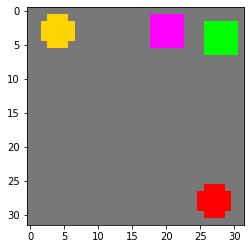

In [5]:
from sort_of_clevr import question2str, answer2str
# IPYthon 상에서 matplotlib 라이브러리가 
# 별도의 창 없이 즉시 plot을 출력할 수 있도록 설정을 변경합니다.
%matplotlib inline

# 이미지를 시각화합니다. train set의 0번째 (img, q, a) 쌍을 시각화합니다.
plt.imshow(Image.fromarray(img_tr[0], 'RGB'))
print ('Question: '+question2str(q_tr[0]))

# 각 Question은 size 11을 갖는 vector로 encoding됩니다.
print ('Question (encoded): '+str(q_tr[0].astype(np.int8)))

print()
print ('Answer: '+answer2str(ans_tr[0]))
# 각 Answer은 size 10을 갖는 vector로 encoding됩니다.
print ('Answer (encoded): '+str(ans_tr[0].astype(np.int8)))
print()

### Q1-1. 
위의 code snippet을 확장하여 다른 split의 데이터셋에 대하여, 임의의 `idx`-번 데이터를 시각화 하는 함수 `visualize(split, idx)`를 구현해 보세요. 위의 출력 형식을 굳이 따르지 않아도 괜찮습니다. 다른 샘플을 직접 시각화 해보고 전반적으로 데이터셋을 파악하시길 바랍니다.

In [6]:
def visualize(split='train', idx=0): 
    ###################### MODIFY HERE ######################
    if split == 'train':
        img, q, ans = train_dataset.query_dataset()
    else:
        img, q, ans = val_dataset.query_dataset()

    # 이미지를 시각화합니다. train set의 0번째 (img, q, a) 쌍을 시각화합니다.
    plt.imshow(Image.fromarray(img[idx], 'RGB'))
    print ('Question: '+question2str(q[idx]))

    # 각 Question은 size 11을 갖는 vector로 encoding됩니다.
    print ('Question (encoded): '+str(q[idx].astype(np.int8)))

    print()
    print ('Answer: '+answer2str(ans[idx]))
    # 각 Answer은 size 10을 갖는 vector로 encoding됩니다.
    print ('Answer (encoded): '+str(ans[idx].astype(np.int8)))
    print()
    #########################################################

### Part 1-3. 사전 학습된 베이스라인 모델 사용해보기 
간단한 합성곱 신경망 (CNN) 기반 모델 (baseline)이 준비되어 있습니다. Tensorflow에서 모델을 불러들이고 샘플 이미지를 넣어서 어떤 결과가 나오는지 확인해봅니다.

In [7]:
from sort_of_clevr import Q_DIM, NUM_ANS
from input_ops import create_input_ops
from models.baseline import Model as Baseline

# 저장된 모델의 경로입니다.
checkpoint_dir = 'pretrained/baseline-default/SortOfCLEVR_4_200000_32_lr_0.0001/'

# 모델을 로드하기 전 현재 computation graph를 초기화합니다.
tf.reset_default_graph()

# 모델을 정의합니다.
# Q_DIM 및 NUM_ANS는 각각 Sort-of-CLEVR 데이터셋의 question과 answer 벡터의 차원을 의미합니다.
baseline = Baseline(Q_DIM, NUM_ANS)

# forward pass를 정의합니다.
batch_size = 1
img = tf.placeholder(
            name='img', dtype=tf.float32,
            shape=[batch_size, 32, 32, 3],
        )
q = tf.placeholder(name='q', dtype=tf.float32, shape=[batch_size, Q_DIM])
a = tf.placeholder(name='a', dtype=tf.float32, shape=[batch_size, NUM_ANS])

logits = baseline.build(img, q)
preds = tf.nn.softmax(logits)

# 모댈 save/load를 위한 객체입니다.
saver = tf.train.Saver()

# computational graph를 실행하기 위한 Session을 선언합니다. 
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

# 저장된 parameter를 불러옵니다.
saver.restore(sess, checkpoint_dir+'model-45000')
print("Model restored.")

# validation dataset에서 샘플을 가져오는 TensorFlow op를 정의합니다.
# 해당 op를 run() 하여 얻은 데이터는 위에서 정의한 placeholder에 feed하기 위해서 사용됩니다.
val_batch = create_input_ops(val_dataset, batch_size)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:Restoring parameters from pretrained/baseline-default/SortOfCLEVR_4_200000_32_lr_0.0001/model-45000
Model restored.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [8]:
# (img, q, ans) 쌍을 하나 뽑아 불러온 모델에 통과시켜봅시다.

# val_batch op를 실행하여 필요한 데이터 batch를 계산합니다.
img_, q_, a_ = sess.run(val_batch)

# 계산한 batch를 placeholder로 이동시키고, 모델을 실행합니다.
preds_ = sess.run(
        fetches=preds, feed_dict={
            img: img_,  # [B, h, w, c]
            q: q_,  # [B, n]
            # 모델의 is_training flag를 False로 설정함으로써,
            # 예상치 못한 파라미터의 업데이트 및 randomness를 (예: Dropout 레이어) 방지합니다.
            baseline.is_training: False
        }
    )

# 모델의 prediction을 출력합니다. answer와 같은 size를 갖습니다.
print ('Prediction: '+str(preds_[0]))

Prediction: [4.6487278e-07 8.4563845e-10 1.0185819e-06 1.1643248e-06 2.0212392e-05
 4.3717469e-07 5.6010932e-01 4.3986741e-01 1.6413950e-09 2.3562054e-08]


### Q1-2. 
위의 Q1-1에서 작성하신 `visualize()` 함수를 변형하여, 주어진 `(img, q, a)` 쌍 및 임의의 prediction `pred`의 실제 답을 비교 및 시각화 하는 함수 `visualize_sample(img, q, a, pred=None)`를 구현해 보세요. 기존 구현에 추가로, 이번에는 `pred=None`이 아닐 경우에는 prediction의 시각화도 생성하도록 구현합시다. 위에서 로드한 베이스라인 모델의 다양한 prediction을 시각화 해보면서 모델의 성능을 파악해보시길 바랍니다.

Question: [Query object color: green] [Query: is it a circle or a rectangle?]
Question (encoded): [0 1 0 0 0 0 1 0 0 0 0]

Answer: [Answer: rectangle]
Answer (encoded): [0 0 0 0 0 0 0 1 0 0]

Prediction: [Answer: circle]
Answer (encoded): [0 0 0 0 0 0 0 0 0 0]



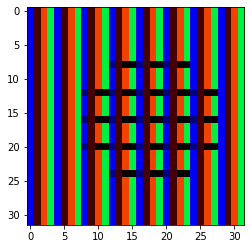

In [9]:
def visualize_sample(img, q, ans, pred=None):
    ###################### MODIFY HERE ######################
    # 이미지를 시각화합니다. train set의 0번째 (img, q, a) 쌍을 시각화합니다.
    plt.imshow(Image.fromarray(img, 'RGB'))
    print ('Question: '+question2str(q))

    # 각 Question은 size 11을 갖는 vector로 encoding됩니다.
    print ('Question (encoded): '+str(q.astype(np.int8)))

    print()
    print ('Answer: '+answer2str(ans))
    # 각 Answer은 size 10을 갖는 vector로 encoding됩니다.
    print ('Answer (encoded): '+str(ans.astype(np.int8)))
    print()

    if pred is not None:
        print ('Prediction: '+answer2str(pred))
        print ('Answer (encoded): '+str(pred.astype(np.int8)))
        print()
    #########################################################

visualize_sample(img_[0], q_[0], a_[0], preds_[0])

프로젝트 디렉토리 내에 있는 `evaler.py`는 저장된 모델을 로드하여 성능을 평가하는 스크립트입니다. 
주어진 데이터셋의 **test set** split을 로드하고, 각 질문에 대한 prediction 중에 답을 맞춘 비율을 계산하여 accuracy를 측정합니다. 또한, 비관계형과(non-relational) 관계형 (relational) 질문에 한정한 accuracy또한 함께 계산해주기 때문에 모델의 성능을 평가하는데 유용하게 사용하실 수 있습니다. 스크립트의 세부 실행 옵션은 다음과 같습니다.
* `--model`: 해당 모델의 아키텍쳐를 의미합니다. 본 실습에서는 `baseline`, `rn`, `film` 중 한 가지를 사용합니다.
* `--train_dir`: 저장된 모델 파라미터가 존재하는 디렉토리를 지정합니다.
* `--dataset_path`: 평가를 위한 데이터셋이 있는 디렉토리 경로를 지정합니다.

다음 스크립트를 실행하며 베이스라인 모델의 test set accuracy를 측정할 수 있습니다:

In [10]:
!python3 evaler.py --model baseline --train_dir pretrained/baseline-default/SortOfCLEVR_4_200000_32_lr_0.0001/ --dataset_path datasets/SortOfCLEVR_4_200000_32

ec/batch, 10795.038 instances/sec) 
[2020-08-05 15:36:16,240]  [test  222] Acc.: 82.00% (0.004 sec/batch, 11126.655 instances/sec) 
[2020-08-05 15:36:16,244]  [test  223] Acc.: 64.00% (0.005 sec/batch, 10960.343 instances/sec) 
[2020-08-05 15:36:16,249]  [test  224] Acc.: 82.00% (0.005 sec/batch, 10735.907 instances/sec) 
[2020-08-05 15:36:16,254]  [test  225] Acc.: 76.00% (0.004 sec/batch, 11255.646 instances/sec) 
[2020-08-05 15:36:16,259]  [test  226] Acc.: 74.00% (0.005 sec/batch, 10224.025 instances/sec) 
[2020-08-05 15:36:16,263]  [test  227] Acc.: 76.00% (0.005 sec/batch, 10993.091 instances/sec) 
[2020-08-05 15:36:16,268]  [test  228] Acc.: 70.00% (0.004 sec/batch, 11226.724 instances/sec) 
[2020-08-05 15:36:16,273]  [test  229] Acc.: 66.00% (0.005 sec/batch, 9591.365 instances/sec) 
[2020-08-05 15:36:16,278]  [test  230] Acc.: 74.00% (0.005 sec/batch, 10515.203 instances/sec) 
[2020-08-05 15:36:16,283]  [test  231] Acc.: 72.00% (0.005 sec/batch, 10693.208 instances/sec) 
[2020

### Part 1-5. Sort-of-CLEVR-2 & -6 생성 및 베이스라인 모델의 데이터셋 일반화 성능 측정
지금까지 사용했던 Sort-of-CLEVR 데이터셋은 각 이미지별 도형의 수가 4개였습니다. 만약 도형의 수가 바뀐 새로운 데이터셋에서 기존 모델을 테스트한다면 성능이 유지될 수 있을까요? 도형의 수가 2개, 6개인 데이터셋을 생성하여 확인해봅시다. `generator.py`코드를 통해 데이터 생성 시 `--num_shapes` 옵션으로 조절할 수 있습니다.

In [ ]:
# 도형이 2개인 Sort-of-CLEVR-2 데이터셋을 생성합니다.
!python3 generator.py --num_shapes 2

In [ ]:
# 도형이 6개인 Sort-of-CLEVR-6 데이터셋을 생성합니다.
!python3 generator.py --num_shapes 6

### Q1-3. 

여러분은 Q1-2에서 데이터를 시각화하는 `visualize_sample(img, q, a, pred=None)` 함수를 구현하였습니다. 이 함수를 재사용하여, 위에서 생성한 Sort-of-CLEVR-2와 -6 데이터셋에서 `(img, q, a)` 쌍을 로드하여 시각화해보세요.

[2020-08-05 15:37:59,121] Reading ./datasets/SortOfCLEVR_2_200000_32/data.hy ...
[2020-08-05 15:37:59,122] Reading Done: ./datasets/SortOfCLEVR_2_200000_32/data.hy
[2020-08-05 15:37:59,123] Reading ./datasets/SortOfCLEVR_2_200000_32/data.hy ...
[2020-08-05 15:37:59,123] Reading Done: ./datasets/SortOfCLEVR_2_200000_32/data.hy
Question: [Query object color: blue] [Query: is it on the left of the image?]
Question (encoded): [1 0 0 0 0 0 0 0 1 0 0]

Answer: [Answer: yes]
Answer (encoded): [0 0 0 0 0 0 0 0 1 0]



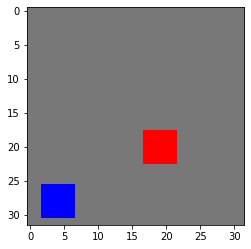

In [14]:
# Soft-of-CLEVR-2
train_dataset = SortOfCLEVR('./datasets/SortOfCLEVR_2_200000_32', split='train')
val_dataset = SortOfCLEVR('./datasets/SortOfCLEVR_2_200000_32', split='val')

img, q, ans = train_dataset.query_dataset()
visualize_sample(img[0], q[0], ans[0])

[2020-08-05 15:38:11,294] Reading ./datasets/SortOfCLEVR_6_200000_32/data.hy ...
[2020-08-05 15:38:11,298] Reading Done: ./datasets/SortOfCLEVR_6_200000_32/data.hy
[2020-08-05 15:38:11,300] Reading ./datasets/SortOfCLEVR_6_200000_32/data.hy ...
[2020-08-05 15:38:11,302] Reading Done: ./datasets/SortOfCLEVR_6_200000_32/data.hy
Question: [Query object color: red] [Query: is it a circle or a rectangle?]
Question (encoded): [0 0 1 0 0 0 1 0 0 0 0]

Answer: [Answer: circle]
Answer (encoded): [0 0 0 0 0 0 1 0 0 0]



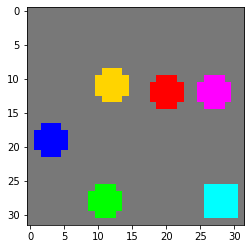

In [15]:
# Soft-of-CLEVR-6
train_dataset = SortOfCLEVR('./datasets/SortOfCLEVR_6_200000_32', split='train')
val_dataset = SortOfCLEVR('./datasets/SortOfCLEVR_6_200000_32', split='val')

img, q, ans = train_dataset.query_dataset()
visualize_sample(img[0], q[0], ans[0])

### Q1-4.

`evaler.py` 스크립트를 통해 Sort-of-CLEVR-2 및 Sort-of-CLEVR-6 데이터셋에 대해서도 베이스라인 모델의 성능을 측정하고, 결과를 정리해 봅시다. 위 스크립트의 출력을 읽고 측정된 accuracy를 입력하여 아래 빈 표를 완성해 보세요.

In [16]:
!python3 evaler.py --model baseline --train_dir pretrained/baseline-default/SortOfCLEVR_2_200000_32_lr_0.0001/ --dataset_path datasets/SortOfCLEVR_2_200000_32

08-05 15:49:40,418]  [test  220] Acc.: 6.00% (0.016 sec/batch, 3055.915 instances/sec) 
[2020-08-05 15:49:40,435]  [test  221] Acc.: 4.00% (0.017 sec/batch, 2891.188 instances/sec) 
[2020-08-05 15:49:40,453]  [test  222] Acc.: 14.00% (0.018 sec/batch, 2800.646 instances/sec) 
[2020-08-05 15:49:40,471]  [test  223] Acc.: 4.00% (0.017 sec/batch, 2924.817 instances/sec) 
[2020-08-05 15:49:40,489]  [test  224] Acc.: 4.00% (0.018 sec/batch, 2850.708 instances/sec) 
[2020-08-05 15:49:40,506]  [test  225] Acc.: 6.00% (0.017 sec/batch, 2936.324 instances/sec) 
[2020-08-05 15:49:40,523]  [test  226] Acc.: 6.00% (0.017 sec/batch, 2984.420 instances/sec) 
[2020-08-05 15:49:40,541]  [test  227] Acc.: 6.00% (0.017 sec/batch, 2873.677 instances/sec) 
[2020-08-05 15:49:40,559]  [test  228] Acc.: 14.00% (0.017 sec/batch, 2892.783 instances/sec) 
[2020-08-05 15:49:40,577]  [test  229] Acc.: 10.00% (0.018 sec/batch, 2834.602 instances/sec) 
[2020-08-05 15:49:40,593]  [test  230] Acc.: 6.00% (0.016 sec/b

In [17]:
!python3 evaler.py --model baseline --train_dir pretrained/baseline-default/SortOfCLEVR_6_200000_32_lr_0.0001/ --dataset_path datasets/SortOfCLEVR_6_200000_32

est  220] Acc.: 6.00% (0.009 sec/batch, 5381.314 instances/sec) 
[2020-08-05 15:50:01,228]  [test  221] Acc.: 0.00% (0.008 sec/batch, 6095.309 instances/sec) 
[2020-08-05 15:50:01,236]  [test  222] Acc.: 2.00% (0.008 sec/batch, 6295.296 instances/sec) 
[2020-08-05 15:50:01,247]  [test  223] Acc.: 0.00% (0.010 sec/batch, 4862.961 instances/sec) 
[2020-08-05 15:50:01,257]  [test  224] Acc.: 6.00% (0.010 sec/batch, 4905.045 instances/sec) 
[2020-08-05 15:50:01,267]  [test  225] Acc.: 6.00% (0.010 sec/batch, 5046.447 instances/sec) 
[2020-08-05 15:50:01,277]  [test  226] Acc.: 0.00% (0.010 sec/batch, 5003.464 instances/sec) 
[2020-08-05 15:50:01,287]  [test  227] Acc.: 8.00% (0.010 sec/batch, 5001.436 instances/sec) 
[2020-08-05 15:50:01,297]  [test  228] Acc.: 8.00% (0.010 sec/batch, 5229.936 instances/sec) 
[2020-08-05 15:50:01,307]  [test  229] Acc.: 6.00% (0.009 sec/batch, 5304.948 instances/sec) 
[2020-08-05 15:50:01,317]  [test  230] Acc.: 2.00% (0.010 sec/batch, 4980.412 instances/s

| Baseline | Non-Relational (%) | Relational (%) | Overall (%) |
|---|:---:|---:|---:|
| SortOfCLEVR_2 | 5.286343612334802 | 11.210874173837135 | 7.655860349127182 |
| SortOfCLEVR_4 | 84.31160625207849 | 60.72051857392171 | 74.87281795511221 |
| SortOfCLEVR_6 | 2.7271971397688533 | 6.867755203789107 | 4.384039900249377 |

## Part 2. Relation Networks

Part 1에서 측정한 베이스라인 모델의 성능을 기반으로 하여, 이번에는 강의 시간에 다룬 [Relation Networks](https://arxiv.org/abs/1706.01427) (RN) 아키텍쳐를 직접 구현해 보고 해당 아키텍쳐가 베이스라인 모델보다 실제로 더 우수한 성능을 보이는지 확인해 볼 것입니다.


Relational Network는 임의의 CNN 모델을 통과한 feature에 대해 적용할 수 있는 아키텍쳐입니다. 여기서, CNN 모델을 통해 주어진 이미지 `img`는 $D\times D \times C$의 형태를 가지는 feature maps로 변환된다고 가정합니다. RN은 해당 feature maps의 각 픽셀 별 feature vector를 개별적인 object로 고려하고, 주어진 이미지에 $o\in \{o_1,\cdots,o_{D\times D}\}$의 object가 있다고 생각합니다. 이에 따라, 주어진 question $q$에 대해 RN은 다음과 같은 형태로 prediction을 모델링합니다:

$$a = f_{\phi}\left(\sum_{i,j}{g_\theta (o_i, o_j, q)} \right)$$

여기서, $f_\phi$, $g_\theta$ 는 각각 neural network 로 표현되는 함수입니다.  

### Q2.

프로젝트 디렉토리 내의 `models/rn.py` 파일에는 `models/baseline.py`에 기반한 RN 모델의 스켈레톤 코드가 있습니다. 해당 파일을 열어서 구조를 파악해보고, RN으로써 동작하는 모델을 완성하는 것이 목표입니다.
- 입력 feature maps를 계산하기 위한 CNN 모델의 구조는 베이스라인 모델의 구조와 같습니다. 이후 모델 평가 과정에서 베이스라인 모델과의 공평한 비교를 위해 해당 구조는 고정하도록 합니다.
- 본 실습에서는, 위 RN의 정의 상에 주어진 $f_\phi$ 와 $g_\theta$ 모두 2-layer MLP 모델을 가정합니다. 특히, $f_\phi$의 경우는 파일 내부에 정의된 `f_phi()`를 변형하지 않고 그대로 사용하도록 합니다.
- 파일 내부의 `_positional_encoding()` 함수는 각 object에 절대적인 pixel 위치 정보를 feature map에 추가하는 함수입니다. 이는 $g_\theta$ 함수가 object의 위치 정보를 고려하지 않는 구조이기 때문에 추가하는 정보입니다.
- Sort-of-CLEVR 데이터셋의 경우, `q` 및 `ans`가 이미 compact한 vector의 형태로 표현되어 있기 때문에, 본 실습에서는 LSTM과 같은 추가적인 Q-embedding 모델을 사용하지 않을 것입니다. 즉, 주어진 q의 입력을 그대로 RN의 정의를 위해 사용하도록 합니다. 

결과적으로, RN의 정의를 위해 실질적으로 추가가 필요한 것은 (a) ${g_\theta (o_i, o_j, q)}$를 구현하고, (b) 구현한 $g_\theta$와 정의된 $f_\phi$를 이용하여 RN을 정의하는 것입니다.

*Hints* 
- `models/ops.py`로부터 import된 `conv2d`, `fc` layer를 사용하시면 더 쉽게 신경망을 구현할 수 있습니다.
- $g_\theta$를 구현하는 다양한 방법이 있을 수 있습니다. TensorFlow에서 지원되는 병렬 연산의 효과를 최대화하는 구현일수록 좋습니다. 본 구현의 경우, $g_\theta(o_i, o_j, q)$의 계산에서 모든 $o_i$ 및 $o_j$ 조합의 연산을 병렬화 할 수 있습니다.  

<img src="resource/rn_pipeline_1.png" width=500>


<img src="resource/rn_pipeline_2.png" width=400>


다음 명령어를 터미널에 입력하여 Relation Networks 모델의 학습을 시도할 수 있습니다:

In [ ]:
## 본 jupyter notebook 상이 아닌 터미널에 입력해주세요
#python3 trainer.py --model rn

## Part 3. FiLM-based Model

이번에는, 파트 2에서 다루었던 RN과 비슷한 시기에 제시된 VQA 모델 아키텍쳐인 [Feature-wise Linear Modulation](https://arxiv.org/abs/1709.07871) (FiLM)을 구현해보고, 베이스라인 및 RN의 성능과 비교해볼 것입니다. 
FiLM 모델은 임의의 CNN 아키텍쳐에 추가될 수 있는 **FiLM 레이어**를 제시합니다. FiLM 레이어는 특정 CNN 모델에서 발생하는 이미지 `img`의 hidden feature maps에 $F$에 대해 다음과 같은 형태로 feature-wise affine transform을 시행합니다:

$$FiLM(F_{c}|\gamma_{c},\beta_{c}) = \gamma_{c}F_{c}+\beta_{c}$$

여기서, "feature-wise 변환"은 각 채널 내의 pixel끼리 변환에 필요한 파라미터 $(\gamma_{c}, \beta_{c})$를 공유함을 의미합니다. 하나의 FiLM 레이어에 대한 채널 파라미터 $(\gamma_{c}, \beta_{c})$ 을 계산하는데 question의 embedding을 사용합니다:

$$(\gamma_{c}, \beta_{c}) = \text{MLP}(q)$$

따라서, question에 대한 conditional prediction을 모델링할 수 있게 됩니다.

### Q3.

프로젝트 디렉토리 내의 `models/film.py` 파일에는 `models/baseline.py`에 기반한 FiLM 모델의 스켈레톤 코드가 있습니다. 해당 파일을 열어서 구조를 파악해보고, FiLM으로써 동작하는 모델을 완성하는 것이 목표입니다.
- 입력 feature maps를 계산하기 위한 CNN 모델의 구조는 베이스라인 모델의 구조와 같습니다. Part 2와 마찬가지로, 이후 모델 평가 과정에서 베이스라인 모델과의 공평한 비교를 위해 해당 구조는 고정하도록 합니다.
- Part 2에서와 마찬가지로, 본 실습에서는 LSTM과 같은 모델을 사용하지 않을 것입니다. FiLM 레이어의 구현을 위해서는 간단히 주어진 q에 대한 2-layer MLP를 고려하도록 합니다.

결과적으로, FiLM의 정의를 위해 실질적으로 추가가 필요한 것은 (a) question embedding 을 통한 파라미터 계산 $(\gamma_{c}, \beta_{c}) = \text{MLP}(q_i)$를 구현하고, (b) 구현한 $(\gamma_{c}, \beta_{c})$를 이용하여 각 layer별 affine transform을 정의하는 것입니다.

*Hints* 
- $\gamma$, $\beta$ 는 각각의 레이어 별 채널의 수를 합친 갯수의 파라미터를 가집니다.

<img src="resource/film.png">


다음 명령어를 터미널에 입력하여 FiLM 모델의 학습을 시도할 수 있습니다:

In [ ]:
## jupyter notebook이 아닌 터미널에 입력해주세요
#!python3 trainer.py --model film

## Part 4. 구현 모델 간 성능 비교 분석

In [ ]:
## Q4를 위한 구현 모델 class import
from models.rn import Model as RelationNet
from models.film import Model as FiLM

### Q4.

구현 및 학습이 끝난 RN과 FiLM 모델의 체크포인트를 이용해 성능을 평가해봅시다. Part 1에서 수행했던 과정을 참고하여, Sort-of-CLEVR-2, -4, 그리고 -6 을 포함한 데이터셋에서 각 모델의 성능을 비교해 보시길 바랍니다. 또한, 학습된 RN과 FiLM 모델을 로드하고, 주어진 image, question에 대한 prediction을 최소한 5개 이상 시각화하여 비교해봅니다. 구현된 모델 중 해당 평가 지표에서 가장 우수한 성능을 보이는 모델은 무엇인가요?

| RN | Non-Relational (%) | Relational (%) | Overall (%) |
|---|:---:|---:|---:|
| SortOfCLEVR_2 |   |   |   |
| SortOfCLEVR_4 |   |   |   |
| SortOfCLEVR_6 |   |   |   |


| FiLM | Non-Relational (%) | Relational (%) | Overall (%) |
|---|:---:|---:|---:|
| SortOfCLEVR_2 |   |   |   |
| SortOfCLEVR_4 |   |   |   |
| SortOfCLEVR_6 |   |   |   |

## Part 5. 모델 튜닝을 통한 성능 개선

### Q5

만약 더 나은 모델 학습 기법을 사용한다면 성능을 어디까지 올릴 수 있을까요? Part 4에서 관찰한 결과가 달라질 수 있을까요? 다양한 모델 튜닝을 시도해보고, 기존 모델을 유의미하게 개선할 수 있는 기법을 찾아보시길 바랍니다. 
- 현재 학습 코드에서는 (`trainer.py`) validation set을 이용한 model selection을 수행하고 있지 않습니다.
- 학습 과정과 관련된 여러가지 하이퍼파라미터가 있습니다: 예) `--batch_size`, `--learning_rate`, `--lr_weight_decay`
- 학습 데이터셋에 대한 증강 기법을 시도: `sort_of_clevr/dataset.py`
- 모델 아키텍쳐의 수정: 이 경우, 유의미한 성능 변화를 관찰하기 위해 각 비교모델 또한 수정이 필요할 것입니다. 